In [1]:
import src.dependencies.injector as sdi
from src.shared.logger_factory import LoggerFactory
from src.process.data_cleaning.data_cleaning_distributions import jaccard_similarity
from src.shared.utils import get_project_root
from src.model.cluster import Cluster
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv

log = LoggerFactory.logger(__name__)
DEFAULT_PATH = str(get_project_root()) + \
    "/src/scripts/config/create_social_graph_and_cluster_config.yaml"

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg', 'karateclub', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg', 'infomap'}


In [2]:
injector = sdi.Injector.get_injector_from_file(DEFAULT_PATH)
process_module = injector.get_process_module()
dao_module = injector.get_dao_module()
user_activity_getters = {
    "friends": dao_module.get_user_activity_getter(user_activity="friends"),
    "user retweets": dao_module.get_user_activity_getter(user_activity="user retweets"),
    "user retweets ids": dao_module.get_user_activity_getter(user_activity="user retweets ids")
}
user_getter = dao_module.get_user_getter()
user_friend_getter = dao_module.get_user_friend_getter()

def get_user_activities(user_id: str, user_activity: str):
    activities = user_activity_getters[user_activity].get_user_activities(user_id)
    if len(activities) == 0:
        return None
    else:
        return activities

In [3]:
# import pickle
# seed_user = "hardmaru"
# # Load cluster
# with open("initial_clusters_hardmaru.pkl", "rb") as f:
#     clusters = pickle.load(f)
# with open("selected_clusters_2895499182.pkl", "rb") as f:
#     selected_clusters = pickle.load(f)

# # Print cluster users
# for cluster in selected_clusters:
#     users = [user_getter.get_user_by_id(user).screen_name for user in cluster.users]
#     log.info(users)

In [15]:
# More ranking experiments
def get_user_ranks(seed_user_name, cluster, path=DEFAULT_PATH):
    """Returns the top 10 ranked users from the given cluster with the seed id as user's id."""
    def get_user_id(user_name):
        user = user_getter.get_user_by_screen_name(user_name)
        user_id = str(user.id)
        return user_id
    user_id = get_user_id(seed_user_name)
    # apply to all users in cluster
    # cluster.users = [get_user_id(user_id) for user_id in cluster.users]
    
    injector = sdi.Injector.get_injector_from_file(path)
    process_module = injector.get_process_module()

    prod_ranker = process_module.get_ranker()
    con_ranker = process_module.get_ranker("Consumption")
    sosu_ranker = process_module.get_ranker("SocialSupport")
    infl1_ranker = process_module.get_ranker("InfluenceOne")
    infl2_ranker = process_module.get_ranker("InfluenceTwo")

    # Second argument is the return of score_users
    prod_rank, prod = prod_ranker.rank(user_id, cluster)
    con_rank, con = con_ranker.rank(user_id, cluster)
    sosu_rank, sosu = sosu_ranker.rank(user_id, cluster)
    infl1_rank, infl1 = infl1_ranker.rank(user_id, cluster)
    infl2_rank, infl2 = infl2_ranker.rank(user_id, cluster)

    return sosu, infl1, infl2, prod, con


In [5]:
def get_intersection_ranking(prod, con, infl1, infl2):
    """Produces a ranking that is the intersection of the Production,
    Consumption, Influence One, and Influence Two rankings

    Args:
        prod, con, infl1, infl2:
            Are dictionaries where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    prod_ranking = list(sorted(prod, key=lambda x: (prod[x][0], prod[x][1]), reverse=True))
    con_ranking = list(sorted(prod, key=lambda x: (con[x][0], con[x][1]), reverse=True))
    infl1_ranking = list(sorted(prod, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True))
    infl2_ranking = list(sorted(prod, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True))
    top_all = {}
    for i in range(1, len(prod_ranking) + 1):
        top_prod = set(prod_ranking[:i])
        top_con = set(con_ranking[:i])
        top_infl1 = set(infl1_ranking[:i])
        top_infl2 = set(infl2_ranking[:i])
        intersection = top_prod.intersection(
            top_con).intersection(
            top_infl1).intersection(
            top_infl2)

        for user in intersection:
            if user not in top_all:
                top_all[user] = [i, infl2_ranking.index(user)]

        #if len(intersection) >= 20: break
        if len(intersection) >= 10: break

    return sorted(top_all, key=lambda x: (top_all[x][0], top_all[x][1]))

In [6]:
def control_intersection_ranking(sosu, infl1, infl2):
    """Produces a ranking that aggregates the Social Support and Influence One rankings

    Args:
        sosu, infl1:
            Is a dictionary where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    # Get top 20 users from sosu_ranking
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))[:10]
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=False))
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=False))
    # Lowest infl1 scores appear first
    # Lowest infl2 scores appear first
    log.info(f"Sosu score cutoff is {sosu[sosu_ranking[-1]][0]}")
    
    return sosu_ranking

In [7]:
def get_new_intersection_ranking(sosu, infl1, infl2):
    """Produces a ranking that aggregates the Social Support and Influence One rankings

    Args:
        sosu, infl1:
            Is a dictionary where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    # Get top 20 users from sosu_ranking
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=False))
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=False))
    # Plot histogram of inflence 1 scores
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    sns.histplot([infl1[x][0] for x in infl1], ax=axs[0], kde=True, bins=20)
    sns.histplot([infl2[x][0] for x in infl2], ax=axs[1], kde=True, bins=20)
    axs[0].set_title("Influence One")
    axs[1].set_title("Influence Two")
    plt.show()

    sosu_ranking = sosu_ranking[:20]
    # Lowest infl1 scores appear first
    # Lowest infl2 scores appear first
    log.info(f"Sosu score cutoff is {sosu[sosu_ranking[-1]][0]}")
    
    # Remove lowest infl1_ranking users from sosu_ranking until 10 users are left
    for user in infl1_ranking:
        if len(sosu_ranking) <= 10:
            break
        if user in sosu_ranking:
            sosu_ranking.remove(user)
    # Influence 1 with users in sosu_ranking
    lst = [infl1[x][0] for x in sosu_ranking]
    print(lst)
            
        
    return sosu_ranking

In [8]:
def get_new_avg_intersection_ranking(sosu, infl1, infl2):
    """Produces a ranking that aggregates the Social Support and Influence One rankings

    Args:
        sosu, infl1:
            Is a dictionary where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))[:20]
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=False))
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=False))
    avg_infl1_infl2 = {user: min(infl1[user][0], infl2[user][0]) for user in infl1}
    avg_infl1_infl2 = list(sorted(avg_infl1_infl2, key=lambda x: (avg_infl1_infl2[x]), reverse=False))
    # Lowest infl1 scores appear first
    # Lowest infl2 scores appear first
    log.info(f"Sosu score cutoff is {sosu[sosu_ranking[-1]][0]}")
    
    # Remove lowest infl1_ranking users from sosu_ranking until 10 users are left
    for user in avg_infl1_infl2:
        if user in sosu_ranking:
            sosu_ranking.remove(user)
        if len(sosu_ranking) == 10:
            break
    return sosu_ranking

In [9]:
def get_new_min_intersection_ranking(sosu, infl1, infl2):
    """Produces a ranking that aggregates the Social Support and Influence One rankings

    Args:
        sosu, infl1:
            Is a dictionary where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True))
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True))
    # Lowest infl1 scores appear first
    # Lowest infl2 scores appear first
    log.info(f"Sosu score cutoff is {sosu[sosu_ranking[-1]][0]}")
    top_all = {}
    # Remove lowest infl1_ranking users from sosu_ranking until 10 users are left
    for i in range(1, len(sosu_ranking) + 1):
        top_sosu = set(sosu_ranking[:i])
        top_infl1 = set(infl1_ranking[:i])
        intersection = top_sosu.intersection(top_infl1)

        for user in intersection:
            if user not in top_all:
                top_all[user] = [i, infl2_ranking.index(user)]

        #if len(intersection) >= 20: break
        if len(intersection) >= 10: break
    
    return sorted(top_all, key=lambda x: (top_all[x][0], top_all[x][1]))

In [10]:
def get_new_top_avg_intersection_ranking(sosu, infl1, infl2, alpha=0.5):
    """Produces a ranking that aggregates the Social Support and Influence One rankings

    Args:
        sosu, infl1:
            Is a dictionary where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True))
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True))
    # Lowest infl1 scores appear first
    # Lowest infl2 scores appear first
    top_10_infl1 = set(infl1_ranking[:10])
    users = [user_getter.get_user_by_id(x).screen_name for x in infl1_ranking[:10]]
    log.info(f"Top 10 users: {users}")
    # Average of top_10_infl1
    avg_top_10_infl1 = sum([infl1[x][0] for x in top_10_infl1]) / len(top_10_infl1)
    t = alpha * avg_top_10_infl1
    log.info(f"Threshold is {t}")
    # Remove users if infl1 score is less than t
    for user in infl1_ranking:
        if infl1[user][0] < t:
            if user in sosu_ranking:
                sosu_ranking.remove(user)
                
    return sosu_ranking

In [11]:
# seed_user_name = 'hardmaru'
# cluster =  ['ClementDelangue', 'apaszke', 'jjvincent', 'seb_ruder', 'poolio', 'jhamrick', 'roydanroy', 'egrefen', 'ogrisel', 'aidangomezzz', 'stanislavfort', 'CadeMetz', 'fchollet', 'osanseviero', 'peteskomoroch', 'ryan_p_adams', 'andrew_n_carr', 'GaryMarcus', 'alexjc', 'goodfellow_ian', 'JeffDean', 'l2k', 'jeremyphoward', 'alanyttian', 'mervenoyann', 'jennwvaughan', 'suzatweet', 'brandondamos', 'manaalfar', 'tkasasagi', 'Miles_Brundage', 'deliprao', 'natolambert', 'alliekmiller', 'SashaMTL', 'sedielem', 'julien_c', 'dwhitena', 'sarahcat21', 'IAugenstein', 'genekogan', 'bguedj', 'kchonyc', 'shivon', 'mcleavey', 'RichardSocher', 'hiconcep', 'soumithchintala', 'NandoDF', 'nathanbenaich', 'dustinvtran', 'cyrildiagne', 'azeem', '_nateraw', 'korymath', 'AndrewYNg', 'hackingdata', 'GuillaumeLample', 'tsimonite', 'dennybritz', 'goodside', 'jekbradbury', 'samcharrington', 'SanhEstPasMoi', 'mmitchell_ai', 'hardmaru', 'lishali88', 'Thom_Wolf', 'Smerity', 'nickwalton00', 'A_K_Nain', 'mdreid', 'jackclarkSF', 'ylecun', 'clmt', 'abursuc', '_rockt', 'douglas_eck', 'karpathy', 'nickfrosst', 'etzioni', 'kaixhin', 'wightmanr', 'mark_riedl', 'hannawallach', 'sleepinyourhat', 'NaveenGRao', 'adveisner', 'Kyle_L_Wiggers', 'animesh_garg', 'AlphaSignalAI', '841io']
# cluster = Cluster(seed_user_name, cluster)
# sosu, infl1, infl2, prod, con = get_user_ranks(seed_user_name, cluster)

In [12]:
def find_follower_count(user_list: List[str], respecting_list: List[str] = None):
    res = {user_id: 0 for user_id in user_list}
    users = respecting_list if respecting_list else user_getter.get_all_users()
    for u in users:
        friends = user_friend_getter.get_user_friends_ids(str(u))
        if friends:
            for friend in friends:
                friend = str(friend)
                if friend in res:
                    res[friend] += 1

    # Map user ids to screen names
    res = {user_getter.get_user_by_id(user_id).screen_name: res[user_id] for user_id in res}
    return res

def find_followers_in_cluster(user_list: List[str], cluster: Cluster):
    cluster_users = cluster.users
    return find_follower_count(user_list, cluster_users)


# find_follower_count([str(user_getter.get_user_by_screen_name("hardmaru").id)])

In [13]:
def tabulate_rankings(filename: str, cluster, sosu, infl1, infl2):
    # Get top 20 of sosu, infl1, infl2
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))[:20]
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True))[:20]
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True))[:20]

    # Log users
    users = [user_getter.get_user_by_id(x).screen_name for x in sosu_ranking]
    log.info(f"Sosu top 20: {users}")
    users = [user_getter.get_user_by_id(x).screen_name for x in infl1_ranking]
    log.info(f"Infl1 top 20: {users}")
    users = [user_getter.get_user_by_id(x).screen_name for x in infl2_ranking]
    log.info(f"Infl2 top 20: {users}")

    # Save csv file with columns user | sosu | infl1 | infl2
    with open(f"{filename}.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["user", "sosu", "infl1", "infl2", "followers", "followers_in_db", "followers_in_cluster"])
        follower_counts = find_follower_count(sosu_ranking)
        follower_counts_in_cluster = find_followers_in_cluster(sosu_ranking, cluster)
        for user in sosu_ranking:
            user_obj = user_getter.get_user_by_id(user)
            name = user_obj.screen_name
            writer.writerow([name, sosu[user][0], infl1[user][0], infl2[user][0], user_obj.followers_count, follower_counts[name], follower_counts_in_cluster[name]])
    

In [17]:
# Loop through all files in ./data that start with "selected_clusters"
import os
import re
import pickle

for file in os.listdir("./data"):
    filename = os.fsdecode(file)
    if filename.startswith("selected_clusters"):
        with open(f"./data/{filename}", "rb") as f:
            clusters = pickle.load(f)
            # Return the chars after "selected_clusters_"
            name = re.search(r"selected_clusters_(.*)", filename).group(1)
            # Split on the first underscore
            user_id = name.split("_", 1)[0]
            seed_user_name = user_getter.get_user_by_id(user_id).screen_name
            root_csv_name = seed_user_name + "_" + name
            for i, cluster in enumerate(clusters):
                csv_name = f"./tables/{root_csv_name}_{i+1}"
                log.info("Tabulating cluster " + str(csv_name))
                sosu, infl1, infl2, prod, con = get_user_ranks(seed_user_name, cluster)
                tabulate_rankings(csv_name, cluster, sosu, infl1, infl2)

2023-06-23 21:56:17 - __main__ - INFO - Tabulating cluster ./tables/chessable_4369711156_old_1
100%|██████████| 118/118 [00:06<00:00, 19.28it/s]
2023-06-23 21:56:45 - __main__ - INFO - Sosu top 20: ['FIDE_chess', 'chesscom', 'ChesscomLive', 'chess24com', 'davidllada', 'chesscom_in', 'ChampChessTour', 'ChessbaseIndia', 'itherocky', 'TarjeiJS', 'anishgiri', 'chessable', 'ruchess_ru', 'riga_niki', 'ChessifyMe', 'HerediaCarla', 'Rameshchess', 'DavidHowellGM', 'chess24es', 'tatasteelchess']
2023-06-23 21:56:45 - __main__ - INFO - Infl1 top 20: ['HansMokeNiemann', 'SunwayChessOpen', 'advorkovich', 'london_chess', 'GMJuditPolgar', 'DavidHowellGM', 'chessqueen', 'FIDE_chess', 'chesscom', 'Rameshchess', 'stuthefox', 'ChessClassic', 'riga_niki', 'viditchess', 'adhibanchess', 'ChampChessTour', 'sadhwani2005', 'chessvaishali', 'anishgiri', 'chesscom_in']
2023-06-23 21:56:45 - __main__ - INFO - Infl2 top 20: ['FIDE_chess', 'ChesscomLive', 'chess24com', 'davidllada', 'ChessbaseIndia', 'chesscom', 'C

In [32]:
def get_ranking_score_by_screen_name(screen_name: str, score) -> float:
    user_id = user_getter.get_user_by_screen_name(screen_name).id
    print(score[str(user_id)][0])
# get_ranking_score_by_screen_name("hardmaru", sosu)

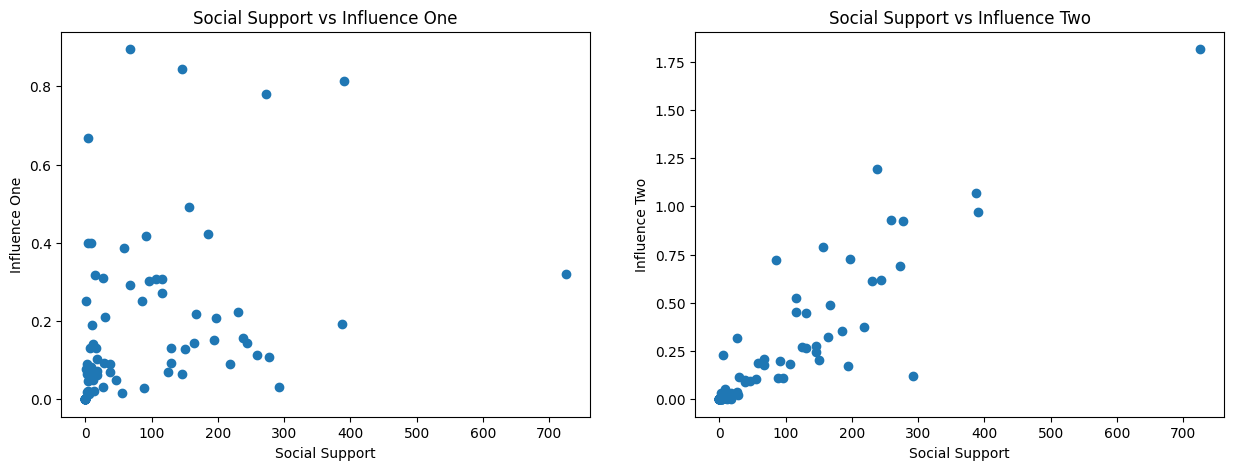

In [34]:
# Plot sosu vs infl1, infl2
fig, (ax1, ax2) = plt.subplots(1, 2)
fig = fig.set_size_inches(15, 5)
ax1.scatter([sosu[user][0] for user in sosu], [infl1[user][0] for user in sosu])
ax1.set_xlabel("Social Support")
ax1.set_ylabel("Influence One")
ax1.set_title("Social Support vs Influence One")
ax2.scatter([sosu[user][0] for user in sosu], [infl2[user][0] for user in sosu])
ax2.set_xlabel("Social Support")
ax2.set_ylabel("Influence Two")
ax2.set_title("Social Support vs Influence Two")
plt.show()

In [35]:
control_sosu_ranking = control_intersection_ranking(sosu, infl1, infl2)
control_sosu_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in control_sosu_ranking]
log.info(control_sosu_ranking_names)

2023-06-23 21:04:05 - __main__ - INFO - Sosu score cutoff is 230.0
2023-06-23 21:04:05 - __main__ - INFO - ['ClementDelangue', 'Thom_Wolf', 'hardmaru', 'nathanbenaich', 'jeremyphoward', 'karpathy', 'ylecun', 'mmitchell_ai', 'jekbradbury', 'egrefen']


In [36]:
old_intersection_ranking = get_intersection_ranking(prod, con, infl1, infl2)
old_intersection_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in old_intersection_ranking]
log.info(old_intersection_ranking_names)

2023-06-23 21:04:05 - __main__ - INFO - ['ClementDelangue', 'Thom_Wolf', 'egrefen', '_rockt', 'NandoDF', 'hardmaru', 'aidangomezzz', 'poolio', 'SashaMTL', 'natolambert', 'jackclarkSF']


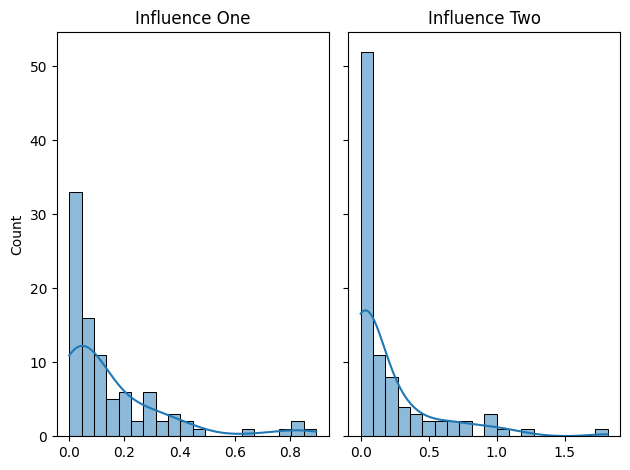

2023-06-23 21:04:05 - __main__ - INFO - Sosu score cutoff is 146.0
2023-06-23 21:04:05 - __main__ - INFO - ['ClementDelangue', 'Thom_Wolf', 'hardmaru', 'karpathy', 'egrefen', 'NandoDF', 'suzatweet', '_rockt', 'poolio', 'SanhEstPasMoi']


[0.31902654867256636, 0.8125, 0.19317023445463813, 0.7807807807807807, 0.22286821705426357, 0.20806100217864923, 0.4219114219114219, 0.218707015130674, 0.49169435215946844, 0.8439306358381503]


In [37]:
new_sosu_ranking = get_new_intersection_ranking(sosu, infl1, infl2)
# Print user names
# Diff only mmitchell_ai removed -- better since theyre not a researcher
new_sosu_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in new_sosu_ranking]
log.info(new_sosu_ranking_names)

In [38]:
new_avg_sosu_ranking = get_new_avg_intersection_ranking(sosu, infl1, infl2)
# Print user names
new_avg_sosu_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in new_avg_sosu_ranking]
log.info(new_avg_sosu_ranking_names)

2023-06-23 21:04:05 - __main__ - INFO - Sosu score cutoff is 146.0
2023-06-23 21:04:05 - __main__ - INFO - ['ClementDelangue', 'Thom_Wolf', 'hardmaru', 'karpathy', 'egrefen', 'NandoDF', 'suzatweet', '_rockt', 'poolio', 'SanhEstPasMoi']


In [39]:
new_avg_sosu_ranking = get_new_min_intersection_ranking(sosu, infl1, infl2)
# Print user names
new_avg_sosu_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in new_avg_sosu_ranking]
log.info(new_avg_sosu_ranking_names)

2023-06-23 21:04:05 - __main__ - INFO - Sosu score cutoff is 0.0
2023-06-23 21:04:05 - __main__ - INFO - ['Thom_Wolf', 'karpathy', 'ClementDelangue', 'suzatweet', 'poolio', 'SanhEstPasMoi', 'egrefen', '_rockt', 'JeffDean', 'NandoDF', 'sleepinyourhat']


In [40]:
new_avg_sosu_ranking = get_new_top_avg_intersection_ranking(sosu, infl1, infl2)
# Print user names
new_avg_sosu_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in new_avg_sosu_ranking]
log.info(new_avg_sosu_ranking_names)

2023-06-23 21:04:05 - __main__ - INFO - Top 10 users: ['sedielem', 'SanhEstPasMoi', 'Thom_Wolf', 'karpathy', 'adveisner', 'poolio', 'suzatweet', 'natolambert', 'GuillaumeLample', 'jhamrick']
2023-06-23 21:04:05 - __main__ - INFO - Threshold is 0.3065244965115491
2023-06-23 21:04:05 - __main__ - INFO - ['ClementDelangue', 'Thom_Wolf', 'karpathy', 'suzatweet', 'poolio', 'SanhEstPasMoi', 'sleepinyourhat', 'jackclarkSF', 'natolambert', 'sedielem', 'soumithchintala', 'nickfrosst', 'dustinvtran', 'GuillaumeLample', 'jhamrick', 'adveisner']


In [41]:
# Set difference both ways
log.info(set(old_intersection_ranking_names) - set(new_sosu_ranking_names))
log.info(set(new_sosu_ranking_names) - set(new_avg_sosu_ranking_names))
log.info(set(new_avg_sosu_ranking_names) - set(new_sosu_ranking_names))
log.info(set(control_sosu_ranking_names) - set(new_sosu_ranking_names))
log.info(set(control_sosu_ranking_names) - set(new_avg_sosu_ranking_names))

2023-06-23 21:04:05 - __main__ - INFO - {'natolambert', 'SashaMTL', 'jackclarkSF', 'aidangomezzz'}
2023-06-23 21:04:05 - __main__ - INFO - {'_rockt', 'egrefen', 'hardmaru', 'NandoDF'}
2023-06-23 21:04:05 - __main__ - INFO - {'natolambert', 'jhamrick', 'sedielem', 'sleepinyourhat', 'nickfrosst', 'dustinvtran', 'jackclarkSF', 'soumithchintala', 'adveisner', 'GuillaumeLample'}
2023-06-23 21:04:05 - __main__ - INFO - {'ylecun', 'jeremyphoward', 'mmitchell_ai', 'jekbradbury', 'nathanbenaich'}
2023-06-23 21:04:05 - __main__ - INFO - {'ylecun', 'egrefen', 'jeremyphoward', 'mmitchell_ai', 'jekbradbury', 'nathanbenaich', 'hardmaru'}


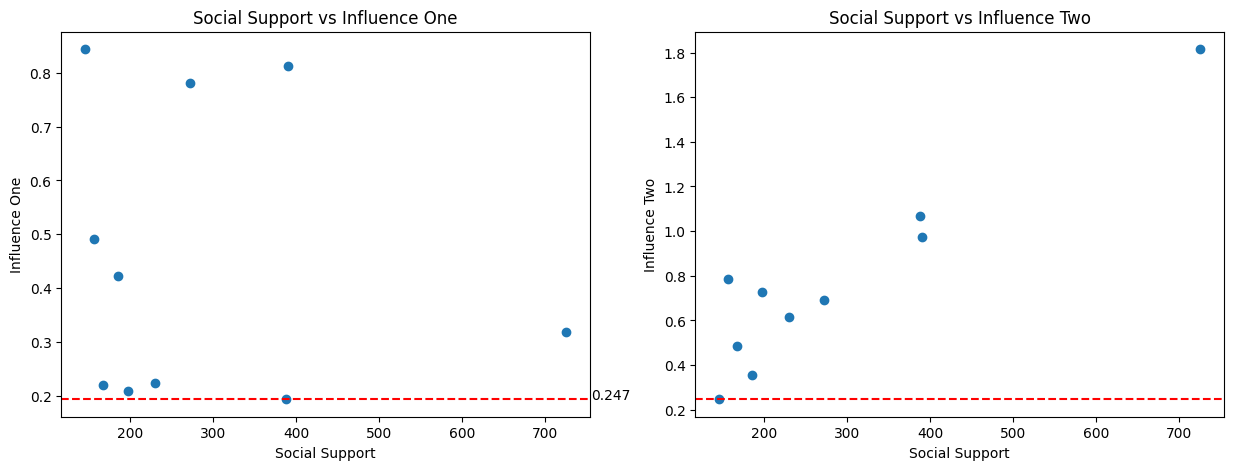

In [42]:
# Plot social support vs infl1 and infl2
fig, (ax1, ax2) = plt.subplots(1, 2)
fig = fig.set_size_inches(15, 5)
ax1.scatter([sosu[user][0] for user in new_sosu_ranking], [infl1[user][0] for user in new_sosu_ranking])
# Plot horizontal line at min infl1 score
min1 = min([infl1[user][0] for user in new_sosu_ranking])
ax1.axhline(y=min1, color='r', linestyle='--')
# Show value of min infl1 score
#ax1.text(-8, min1, f"{min1:.3f}")
ax1.set_xlabel("Social Support")
ax1.set_ylabel("Influence One")
ax1.set_title("Social Support vs Influence One")
ax2.scatter([sosu[user][0] for user in new_sosu_ranking], [infl2[user][0] for user in new_sosu_ranking])
# Plot horizontal line at min infl2 score
min2 = min([infl2[user][0] for user in new_sosu_ranking])
ax2.axhline(y=min2, color='r', linestyle='--')
# Show value of min infl2 score
ax2.text(-8, min2, f"{min2:.3f}")
ax2.set_xlabel("Social Support")
ax2.set_ylabel("Influence Two")
ax2.set_title("Social Support vs Influence Two")
plt.show()